# 08_Modeling: Tune the Random Forest Model after Feature Engineering, try XGBoost and Neural Networks

Date: 2022-06-14

## Prep Data

In [227]:
import os
#os.chdir('..')
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import plotly.express as px
import joblib
import matplotlib.pyplot as plt
import time

In [26]:
# set seed 
np.random.seed(42)

# read in data sets
training_cleaned = pd.read_pickle('cleaned_data/training_cleaned.pkl')
training_prices = pd.read_pickle('cleaned_data/training_prices.pkl')
test_orig = pd.read_csv('data/test.csv')
test = pd.read_pickle('cleaned_data/test_cleaned.pkl')

In [27]:
X = training_cleaned.copy()

#log transform the prices
y = np.log10(training_prices)

In [28]:
X.shape

(1460, 303)

## Random Forest Regression

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [30]:
# create baseline model 
forest_reg = RandomForestRegressor(random_state = 42)
# cross validation 
scores = cross_val_score(forest_reg, X, y, scoring = "neg_mean_squared_error", cv = 3)
rf_rmse_scores = np.sqrt(-scores)
baseline_rmse = rf_rmse_scores.mean()
baseline_rmse

#save model 
joblib.dump(forest_reg, 'Results/models/rf_baseline_feng.sav')

['Results/models/rf_baseline_feng.sav']

In [31]:
baseline_rmse

0.061669998364828706

In [32]:
# see what are default parameters
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [33]:
# create grid 
param_grid = [
    {'n_estimators': [5, 10, 100, 400],
     'max_features': [5, 20, 'auto'],
     'bootstrap': [True, False], 
     'min_samples_split': [2, 5, 8]}] 
grid_search = GridSearchCV(forest_reg, param_grid, cv = 3, scoring = 'neg_mean_squared_error', return_train_score = True, verbose = 3)
grid_search.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=5;, score=(train=-0.002, test=-0.007) total time=   0.0s
[CV 2/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=5;, score=(train=-0.002, test=-0.008) total time=   0.1s
[CV 3/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=5;, score=(train=-0.002, test=-0.007) total time=   0.0s
[CV 1/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=10;, score=(train=-0.001, test=-0.005) total time=   0.0s
[CV 2/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=10;, score=(train=-0.001, test=-0.007) total time=   0.0s
[CV 3/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=10;, score=(train=-0.001, test=-0.006) total time=   0.1s
[CV 1/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.004) 

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [5, 20, 'auto'],
                          'min_samples_split': [2, 5, 8],
                          'n_estimators': [5, 10, 100, 400]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [34]:
# get best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=20, min_samples_split=5,
                      random_state=42)

In [35]:
cvres = grid_search.cv_results_

In [36]:
# get parameters and results
test_rmse = np.sqrt(-cvres['mean_test_score'])
train_rmse = np.sqrt(-cvres['mean_train_score'])
parameters = cvres['params']
bootstrap = [parameters[i]['bootstrap'] for i in range(len(parameters))]
max_features = [parameters[i]['max_features'] for i in range(len(parameters))]
n_estimators = [parameters[i]['n_estimators'] for i in range(len(parameters))]
min_samples_split = [parameters[i]['min_samples_split'] for i in range(len(parameters))]
per_improv = [(baseline_rmse-test)/baseline_rmse for test in test_rmse]

# combine into dataframe

cvrse_df = pd.DataFrame({'test_rmse': test_rmse, 
                        'train_rmse': train_rmse, 
                        'percent_improvement': per_improv, 
                        'bootstrap': bootstrap, 
                        'max_features': max_features, 
                        'n_estimators': n_estimators,
                        'min_samples_split': min_samples_split})

In [37]:
cvrse_df.sort_values(by = 'percent_improvement', ascending = False).head(10)

,test_rmse,train_rmse,percent_improvement,bootstrap,max_features,n_estimators,min_samples_split
54,0.059496,1.177300e-02,0.035249,False,20,100,5
51,0.059683,3.093359e-14,0.032227,False,20,400,2
55,0.059712,1.157963e-02,0.031751,False,20,400,5
50,0.060093,7.795554e-15,0.025564,False,20,100,2
59,0.060265,1.937858e-02,0.022787,False,20,400,8
58,0.060332,1.953616e-02,0.021690,False,20,100,8
27,0.061407,2.315355e-02,0.004264,True,auto,400,2
31,0.061467,2.644959e-02,0.003287,True,auto,400,5
35,0.061593,2.991963e-02,0.001242,True,auto,400,8
15,0.061649,2.312809e-02,0.000344,True,20,400,2


We are back to having very small training error and much larger test error, overfitting! 

### Parallel Coordinates Plot of Hyperparameters

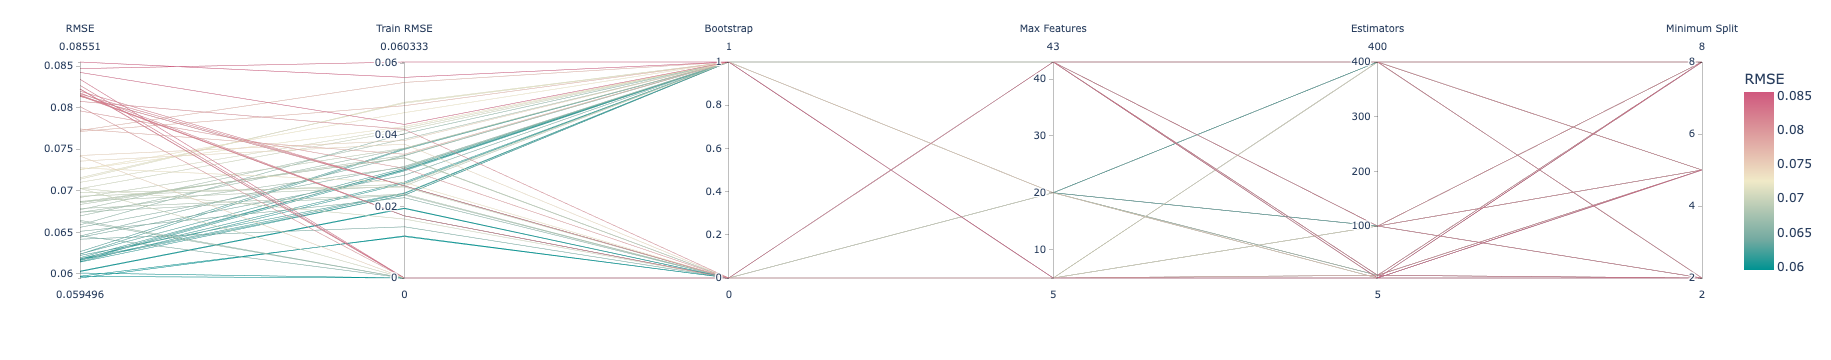

In [38]:
# had to 'pip install "notebook>=5.3" "ipywidgets>=7.2"' for this to show up.
fit_plot = cvrse_df[['test_rmse', 'train_rmse', 'bootstrap', 'max_features', 'n_estimators', 'min_samples_split']].copy()
fit_plot['bootstrap'] = [1 if i else 0 for i in fit_plot['bootstrap']]
fit_plot['max_features'] = [43 if i == 'auto' else i for i in fit_plot['max_features']]
fig = px.parallel_coordinates(fit_plot, color = 'test_rmse', 
                              labels = {'test_rmse': 'RMSE', 
                                        'train_rmse': 'Train RMSE', 
                                        'bootstrap': 'Bootstrap', 
                                        'max_features': 'Max Features', 
                                        'n_estimators': 'Estimators',
                                        'min_samples_split': 'Minimum Split'}, 
                              color_continuous_scale = px.colors.diverging.Tealrose)
fig.show()

In [39]:
# Apply best estimator on test set

model_hp = grid_search.best_estimator_
predictions = model_hp.predict(test)

# function to put predicted data in submission format 
def submission_format(predictions, test_orig):
    """
    predictions: output of predict() from running model 
    test_orig: original test data to get ID 
    
    returns: predictions with ID and applied exponential to undo log transform
    """
    # create data frame with id
    predictions_df = pd.DataFrame({'Id': test_orig['Id'], 
                               'SalePrice': predictions.tolist()})
    # log transform back the sale price
    predictions_df['SalePrice'] = 10**predictions_df['SalePrice']
    
    return predictions_df

predictions_df = submission_format(predictions, test_orig)
predictions_df.head()

predictions_df.to_csv('results/prediction_rf_hp_feng.csv', index = False)

In [40]:
#save model 
joblib.dump(model_hp, 'Results/models/rf_hp_tuned_3.sav')

['Results/models/rf_hp_tuned_3.sav']

## Gradient Boosted Decision Trees

In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

### Create baseline model 

In [78]:
data_dmatrix = xgb.DMatrix(data = X, label = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [80]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 22)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test) 

In [58]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(rmse)

0.05772145490232267


Baseline model seems more promising than random forest regression

### Hyperparameter tuning

In [89]:
params = {'max_depth': [3, 5],
          'learning_rate': [0.05, 0.1, 0.3], 
          'n_estimators': [400, 800, 1500], 
          'colsample_bytree': [0.3, 0.5, 0.7]}

grid_search_gbm = GridSearchCV(xg_reg, params, cv = 3, scoring = 'neg_mean_squared_error', return_train_score = True, verbose = 3)
grid_search_gbm.fit(X, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=400;, score=(train=-0.001, test=-0.002) total time=   0.9s
[CV 2/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=400;, score=(train=-0.001, test=-0.004) total time=   0.8s
[CV 3/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=400;, score=(train=-0.001, test=-0.002) total time=   0.8s
[CV 1/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=800;, score=(train=-0.000, test=-0.002) total time=   1.7s
[CV 2/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=800;, score=(train=-0.000, test=-0.004) total time=   1.5s
[CV 3/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=800;, score=(train=-0.000, test=-0.002) total time=   1.6s
[CV 1/3] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=1500;, score=(tra

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat...
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=22,
    

In [90]:
grid_search_gbm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=22,
             reg_alpha=0, reg_lambda=1, ...)

In [91]:
cvres_gbm = grid_search_gbm.cv_results_

In [93]:
cvres_df = pd.DataFrame(cvres_gbm)
# get parameters and results
test_rmse = np.sqrt(-cvres_df['mean_test_score'])
train_rmse = np.sqrt(-cvres_df['mean_train_score'])
parameters = cvres_df['params']
max_depth = [parameters[i]['max_depth'] for i in range(len(parameters))]
learning_rate = [parameters[i]['learning_rate'] for i in range(len(parameters))]
n_estimators = [parameters[i]['n_estimators'] for i in range(len(parameters))]
colsample_by_tree = [parameters[i]['colsample_bytree'] for i in range(len(parameters))]
#alpha =  [parameters[i]['alpha'] for i in range(len(parameters))]
per_improv = [(baseline_rmse-test)/baseline_rmse for test in test_rmse]

# combine into dataframe

cvrse_df = pd.DataFrame({'test_rmse': test_rmse, 
                        'train_rmse': train_rmse, 
                        'percent_improvement': per_improv, 
                        'max_depth': max_depth, 
                        'learning_rate': learning_rate, 
                      #  'alpha': alpha, 
                        'n_estimators': n_estimators,
                        'colsample_by_tree': colsample_by_tree})

In [94]:
cvrse_df.sort_values(by = 'percent_improvement', ascending = False).head(10)

,test_rmse,train_rmse,percent_improvement,max_depth,learning_rate,n_estimators,colsample_by_tree
23,0.052431,0.001538,0.149815,5,0.05,1500,0.5
22,0.052434,0.005005,0.149766,5,0.05,800,0.5
38,0.052527,0.010196,0.148249,3,0.05,1500,0.7
37,0.052578,0.018224,0.147438,3,0.05,800,0.7
21,0.052612,0.012870,0.146873,5,0.05,400,0.5
19,0.052641,0.018665,0.146415,3,0.05,800,0.5
20,0.052656,0.010827,0.146168,3,0.05,1500,0.5
2,0.052699,0.011618,0.145461,3,0.05,1500,0.3
42,0.052825,0.017731,0.143430,3,0.10,400,0.7
1,0.052832,0.019597,0.143304,3,0.05,800,0.3


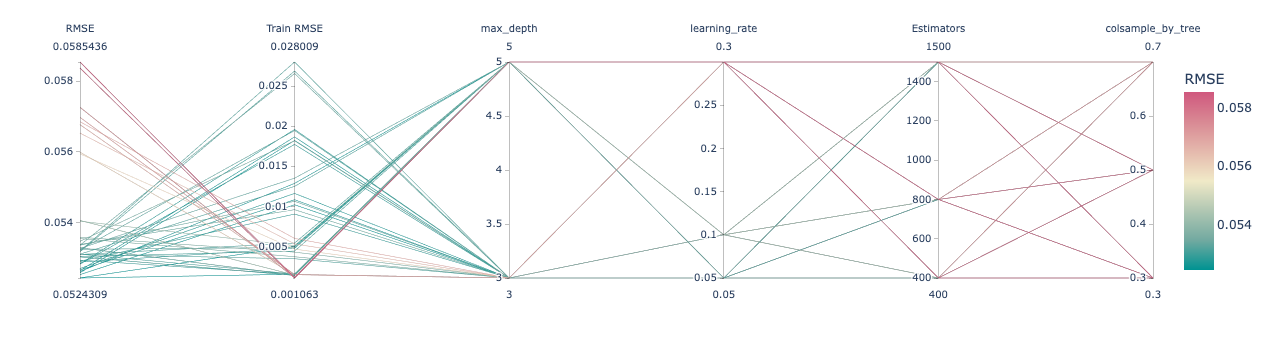

In [95]:
# had to 'pip install "notebook>=5.3" "ipywidgets>=7.2"' for this to show up.
fit_plot = cvrse_df[['test_rmse', 'train_rmse', 'max_depth', 'learning_rate', 'n_estimators', 'colsample_by_tree']].copy()
#fit_plot['bootstrap'] = [1 if i else 0 for i in fit_plot['bootstrap']]
#fit_plot['max_features'] = [43 if i == 'auto' else i for i in fit_plot['max_features']]
fig = px.parallel_coordinates(fit_plot, color = 'test_rmse', 
                              labels = {'test_rmse': 'RMSE', 
                                        'train_rmse': 'Train RMSE', 
                                        'bootstrap': 'Bootstrap', 
                                        'max_features': 'Max Features', 
                                        'n_estimators': 'Estimators',
                                        'min_samples_split': 'Minimum Split',
                                        'alpha': 'alpha'}, 
                              color_continuous_scale = px.colors.diverging.Tealrose)
fig.show()

In [96]:
# Apply best estimator on test set

model_hp = grid_search_gbm.best_estimator_
predictions = model_hp.predict(test)
predictions_df = submission_format(predictions, test_orig)
predictions_df.head()

predictions_df.to_csv('results/prediction_gbm.csv', index = False)

In [97]:
joblib.dump(model_hp, 'results/models/gbm.sav')

['results/models/gbm.sav']

This gets 0.12614 on Kaggle! 

## Practicing Neural Network 

In [101]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [108]:
X_train_torch = torch.from_numpy(X_train.to_numpy()).float()
y_train_torch = torch.from_numpy(y_train.to_numpy()).float()

In [201]:
dataset = TensorDataset(X_train_torch, y_train_torch)

In [202]:
#set seed
torch.manual_seed(1)
batch_size = 1
dataloader = DataLoader(dataset, batch_size, shuffle = True)

In [224]:
class Model(nn.Module): 
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size): 
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, output_size) 
    
    def forward(self, x): 
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        return x

In [225]:
input_size = X_train_torch.shape[1]
hidden_size1 = 16
hidden_size2 = 16
output_size = 1

model = Model(input_size, hidden_size1, hidden_size2, output_size)

In [226]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [228]:
# initialization
start_time = time.time()
num_epochs = 200
loss_hist = [0] * num_epochs

# train!
for epoch in range(num_epochs):
    if epoch % 10 == 0: 
        print('Epoch: ', epoch)
    for x_batch, y_batch in dataloader:
        pred = model(x_batch)
        loss = loss_fn(torch.squeeze(pred), y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item() 
    loss_hist[epoch] = (loss_hist[epoch]/len(dataloader.dataset))**0.5

end_time = time.time()

Epoch:  0


/Users/mnakajim/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90
Epoch:  100
Epoch:  110
Epoch:  120
Epoch:  130
Epoch:  140
Epoch:  150
Epoch:  160
Epoch:  170
Epoch:  180
Epoch:  190


In [229]:
end_time - start_time

213.51418900489807

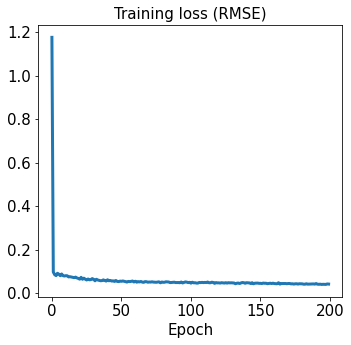

In [217]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw = 3)
ax.set_title("Training loss (RMSE)", size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [218]:
# Try model on test set 
X_test_torch = torch.from_numpy(X_test.to_numpy()).float()
pred_test = model(X_test_torch)

In [219]:
rmse = torch.sqrt(torch.mean((torch.squeeze(pred_test) - torch.from_numpy(y_test.to_numpy()))**2))

In [220]:
rmse

tensor(0.0764, dtype=torch.float64, grad_fn=<SqrtBackward0>)

This is not bad RMSE (but worse than default RF and GBM) and the test RMSE is pretty close to the training RMSE. I think the NN architecture would have to be thought about a bit and hyperparameter tuned to make better. 

In [221]:
# Try model on submission set
pred_submission = model(torch.from_numpy(test.to_numpy()).float())

In [222]:
predictions = torch.squeeze(pred_submission).detach().numpy()
predictions_df = submission_format(predictions, test_orig)
predictions_df.head()

,Id,SalePrice
0,1461,130935.761136
1,1462,150165.421225
2,1463,185925.145896
3,1464,201304.071167
4,1465,193330.626890


In [223]:
predictions_df.to_csv('results/prediction_nn.csv', index = False)